<a href="https://colab.research.google.com/github/shreyanshxt/synthetic-brain-tumor/blob/main/autoencoder_vae_skip_grayscale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as f
from torch.utils.data import DataLoader , Dataset
from PIL import Image
import torchvision.transforms as T
import os

In [7]:
!pip install kaggle


In [8]:
from google.colab import files
files.upload()  # Upload your kaggle.json file


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ligitai","key":"9f3fa7fb02a8cfc31f00ee399cb35f4e"}'}

In [9]:

import os
os.makedirs("/root/.kaggle", exist_ok=True)
!mv kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json


In [10]:
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

api.dataset_download_files('denizkavi1/brain-tumor', path='.', unzip=True)



Dataset URL: https://www.kaggle.com/datasets/denizkavi1/brain-tumor


In [11]:


class Encoder(nn.Module):
  def __init__(self,input_channel=1,latent_channel=4):
    super().__init__()
    self.conv1=nn.Conv2d(input_channel,64,kernel_size=4,stride=2,padding=1)
    self.conv2=nn.Conv2d(64,128,4,2,1)
    self.conv3=nn.Conv2d(128,256,4,2,1)
    self.conv4=nn.Conv2d(256,latent_channel*2,3,2,1)

  def forward(self,x):
    e1=f.relu(self.conv1(x))
    e2=f.relu(self.conv2(e1))
    e3=f.relu(self.conv3(e2))
    h=self.conv4(e3) #mean and logvar
    mean , logvar= torch.chunk(h,2,dim=1)
    return mean,logvar,[e1,e2,e3]
class Decoder(nn.Module):
  def __init__(self,output_channel=1,latent_channel=4):
    super().__init__()
    self.conv1=nn.ConvTranspose2d(latent_channel,256,4,2,1)
    self.conv2=nn.ConvTranspose2d(256+256,128,4,2,1)
    self.conv3=nn.ConvTranspose2d(128+128,64,4,2,1)
    self.conv4=nn.ConvTranspose2d(64+64,output_channel,4,2,1)

  def forward(self,z,skips):
    e1,e2,e3=skips
    z=f.relu(self.conv1(z))
    z=torch.cat([z,e3],dim=1)
    z=f.relu(self.conv2(z))
    z=torch.cat([z,e2],dim=1)
    z=f.relu(self.conv3(z))
    z=torch.cat([z,e1],dim=1)

    return torch.sigmoid(self.conv4(z))
class Autoencoder(nn.Module):
  def __init__(self,input_channel,latent_channel):
    super().__init__()
    self.encoder=Encoder(input_channel,latent_channel)
    self.decoder=Decoder(input_channel,latent_channel)
    self.quant_conv=nn.Conv2d(latent_channel*2,latent_channel*2,1)
    self.post_quant=nn.Conv2d(latent_channel,latent_channel,1)

  def encode(self,x):
    mean,logvar,skips=self.encoder(x)
    h=torch.cat([mean,logvar],dim=1)
    h=self.quant_conv(h)
    mean , logvar= torch.chunk(h,2,dim=1)
    return mean,logvar,skips
  def sample(self,mean,logvar):
    eps=torch.randn_like(mean)
    return mean + eps*torch.exp(logvar*0.5)
  def decode(self,z,skips):
    z=self.post_quant(z)
    return self.decoder(z,skips)
  def forward(self,x):
    mean,logvar,skips=self.encode(x)
    z=self.sample(mean,logvar)
    x_recon=self.decode(z,skips)
    return x_recon,mean,logvar





In [12]:
def vae_loss(x,x_recon,mean,logvar,beta):
  recon_loss=f.mse_loss(x_recon,x,reduction='mean')
  kl_div=0.5*torch.mean(mean.pow(2) + logvar.exp() -1 -logvar)
  return recon_loss+kl_div*beta,kl_div,recon_loss


In [13]:
class gray_scale_img (Dataset):
  def __init__(self,img_dir,img_size=(128,128)):
    self.paths=[ os.path.join(img_dir,f)
                for f in os.listdir(img_dir)
                if f.lower().endswith(('.png','.jpeg','jpg'))
                ]
    self.transform=T.Compose([
        T.Resize(img_size),
        T.ToTensor(),
        T.Grayscale(num_output_channels=1)

    ])
  def __len__(self):
    return len(self.paths)
  def __getitem__(self,idx):
    img=Image.open(self.paths[idx]).convert('L')
    return self.transform(img)

In [14]:
dataset=gray_scale_img("/content/1")
dataloader=DataLoader(dataset,batch_size=16,shuffle=True)

In [15]:
img=Image.open("/content/1/2300.png")
img.size
img.mode


'RGBA'

In [16]:
def train_vae(model,dataloader,optimizer,epoch,beta):
  model.train()
  for epochs in range(epoch):
    total_loss=0
    total_recon=0
    total_kl = 0
    for batch in dataloader:
      optimizer.zero_grad()
      x_recon,mean,logvar=model(batch)
      loss,kl_div,recon_loss=vae_loss(batch,x_recon,mean,logvar,beta=1.0)
      loss.backward()
      optimizer.step()
      total_loss+=loss.item()
      total_recon+=recon_loss.item()
      total_kl+=kl_div.item()
    show_reconstruction(batch, x_recon)
    print(f"Epoch [{epoch}/{epochs}] - Total Loss: {total_loss:.4f} | Recon Loss: {total_recon:.4f} | KL Loss: {total_kl:.4f}")


In [17]:
import matplotlib.pyplot as plt
def show_reconstruction(x, x_recon, n=5):
    n = min(n, x.shape[0])  # prevent index error if batch size is smaller than n
    x = x[:n].detach().cpu()
    x_recon = x_recon[:n].detach().cpu()

    fig, axs = plt.subplots(2, n, figsize=(n * 2, 4))
    for i in range(n):
        axs[0, i].imshow(x[i].permute(1, 2, 0).squeeze(), cmap='gray')
        axs[0, i].axis('off')
        axs[1, i].imshow(x_recon[i].permute(1, 2, 0).squeeze(), cmap='gray')
        axs[1, i].axis('off')
    plt.show()


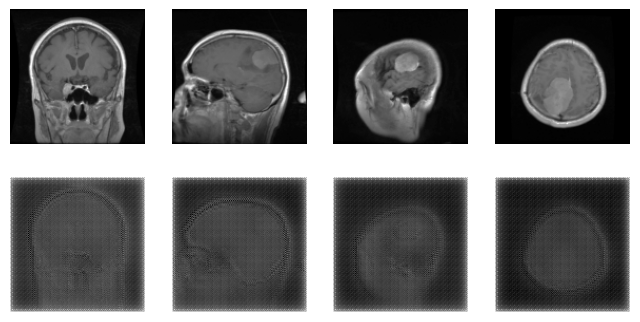

Epoch [10/0] - Total Loss: 2.2513 | Recon Loss: 1.7538 | KL Loss: 0.4975


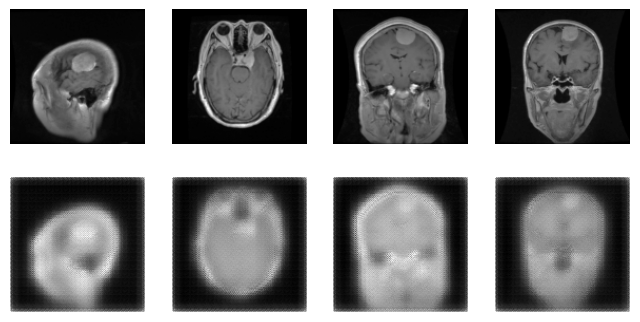

Epoch [10/1] - Total Loss: 0.6238 | Recon Loss: 0.3330 | KL Loss: 0.2908


In [ ]:
vae= Autoencoder(input_channel=1,latent_channel=4)
optimizer=torch.optim.Adam(vae.parameters(),lr=1e-4)
train_vae(vae,dataloader,optimizer,epoch=10,beta=1.5)

In [ ]:
!pip install diffusers[torch] transformers accelerate


In [ ]:
from diffusers import StableDiffusionPipeline

In [ ]:
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16
)

In [ ]:
my_vae=vae.to("cpu").float()
pipe.vae=my_vae